In [1]:
import os
import cv2
import sys
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from skimage import color
from skimage import filters
from skimage.morphology import disk, binary_closing, binary_opening

sys.path.append('/home/phiwei/repos/chimecore')
#from chimecore.image import get_tissue_mask

gpus = tf.config.list_logical_devices('GPU')

2022-11-09 15:25:02.817985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 15:25:02.977064: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-09 15:25:03.505365: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/phiwei/anaconda3/envs/staingan/lib/python3.9/site-packages/cv2/../../../../lib::/home/phiwei/anaconda3/envs/staingan/lib/:/home/phiwei/anaconda3/envs/staingan/lib/
2022-11-09 15:25:03.505456: W tensorflow/s

In [2]:
lvl = 6

if lvl == 6:
    path_imgs_base = '/mnt/ssd2tb/phiwei/acrobat_train_low_res/6/source/'
    path_imgs_base = '/mnt/ssd2tb/phiwei/6_test_inspected/'
    path_model = '/mnt/hdd8tb/phiwei/staingan/staingan6-2022-11-05_12-09-52/checkpoint/source_to_target_199.h5'
elif lvl == 5:
    path_imgs_base = '/mnt/ssd2tb/phiwei/acrobat_train_low_res/5/source/'
    path_model = '/mnt/hdd8tb/phiwei/staingan/staingan5-2022-11-06_07-03-21/'
    
    
path_masks_base = '/mnt/ssd2tb/phiwei/acrobat_test_mask/data/staff/budelmann/acrobat_test/'

In [3]:
class ReflectionPadding2D(tf.keras.layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_w, padding_h = self.padding
        padding_tensor = [
            [0, 0],
            [padding_h, padding_h],
            [padding_w, padding_w],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


    def get_config(self):
        config = super().get_config().copy()
        config.update({"padding": self.padding})
        return config
    
def load_image(img_path):
    assert os.path.exists(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def get_tissue_mask(arr,
                    h_min=135, h_max=179,
                    s_min=None, s_max=255,
                    v_min=0, v_max=255,
                    var_min=20, lp_kernel_size=3,
                    sp_disk_radius=10, otsu_max=25, 
                    use_laplacian=False):
    """
    Get tissue mask for an RGB image.
    :param arr: (ndarray, np.uint8) RGB
    :param h_min: minimum hue angle
    :param h_max: maximum hue angle
    :param s_min: minimum saturation
    :param s_max: maximum saturation
    :param v_min: minimum value
    :param v_max: maximum value
    :param var_min: minimum variance
    :param lp_kernel_size: (int) Laplacian
        kernel size
    :param sp_disk_radius: (int) salt and pepper
        removal disk radius
    :param otsu_max: (int) maximum value for 
        threshold on saturation channel
    :param use_laplacian: (bool) whether to use
        laplacian variance mask as part of
        tissue mask
    :return: (ndarray, np.uint8)
    """

    assert arr.dtype == np.uint8, 'Make sure your array is np.uint8'
    assert arr.max() > 1, 'Expecting array in value range [0, 255]'

    if s_min is None:
        s_min = get_otsu_threshold(arr)
    
    if otsu_max is not None:
        if s_min > otsu_max:
            s_min = otsu_max

    # Get HSV mask
    mask_hsv = threshold_hsv(arr, h_min, h_max, s_min, s_max, v_min, v_max)

    # Get Laplacian
    if use_laplacian:
        mask_laplace = get_high_gradient_mask(arr, lp_kernel_size, var_min)

        # Combine masks
        mask = mask_hsv & mask_laplace
    else:
        mask = mask_hsv > 0

    # Remove salt and pepper noise from mask
    mask = apply_salt_and_pepper(mask, disk_radius=sp_disk_radius)

    # Typecast since typically we want uint8 for openCV
    mask = mask.astype(np.uint8)

    return mask


def get_otsu_threshold(arr):
    """
    Get otsu threshold of
    saturation channel.
    :param arr: (ndarray) RGB image
    :return: (float or int)
    """
    arr_tmp = color.convert_colorspace(arr, 'RGB', 'HSV')[..., 1]
    otsu = filters.threshold_otsu(arr_tmp)
    if arr.max() > 1:
        otsu = int(otsu * 255)
    return otsu


def threshold_hsv(arr, h_min, h_max, s_min, s_max, v_min, v_max):
    """
    Get a mask for an RGB image by identifying which pixels
    are in the allowed range as defined by *_min and *_max
    values.
    :param arr: (ndarray) RGB
    :param h_min: minimum hue angle
    :param h_max: maximum hue angle
    :param s_min: minimum saturation
    :param s_max: maximum saturation
    :param v_min: minimum value
    :param v_max: maximum value
    :return: (ndarray) boolean
    """
    # Set minimum and maximum HSV values to display
    lower = np.array([h_min, s_min, v_min])
    upper = np.array([h_max, s_max, v_max])

    # Convert to HSV format and color threshold
    hsv = cv2.cvtColor(arr, cv2.COLOR_RGB2HSV)
    mask_hsv = cv2.inRange(hsv, lower, upper)
    return mask_hsv


def apply_salt_and_pepper(mask, disk_radius=10):
    """
    First, remove pepper, small false regions,
    then remove salt, small true regions.
    :param mask: (ndarray) boolean mask
    :param disk_radius: (int)
    :return: (ndarray) boolean mask
    """
    if mask.max() > 1:
        scaled = True
        mask_max = mask.max()
        mask = mask / mask_max
    else:
        scaled = False
    
    disk_object = disk(disk_radius, dtype='bool')
    mask = binary_closing(mask, disk_object)  # remove pepper
    mask = binary_opening(mask, disk_object)  # remove salt
    
    if scaled:
        mask = (mask*mask_max).astype(np.uint8) 
        
    return mask


def get_high_gradient_mask(arr, kernel_size=3, var_min=20):
    """
    True pixels in mask are regions of high
    gradient. Low gradient regions are
    often artifacts such as glue or pen mark
    or blurry regions. The True mask pixels
    should correspond to tissue.
    :param arr: (ndarray) RGB
    :param kernel_size: (int) size of kernel
    :param var_min: (int) minimum variance
    :return: (ndarray) bool
    """
    gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    ddepth = cv2.CV_16S
    dst = cv2.Laplacian(gray, ddepth, kernel_size)
    mask = cv2.convertScaleAbs(dst) > var_min
    return mask

/mnt/ssd2tb/phiwei/6_test_inspected/177_ER_test.jpg
(1736, 3520, 3)


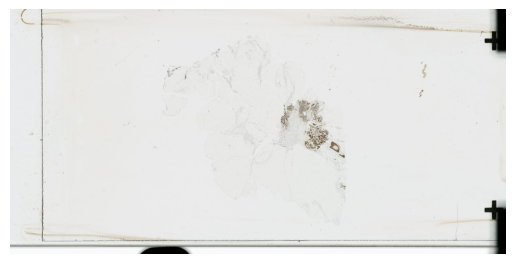

In [4]:
img_filenames = os.listdir(path_imgs_base)
if lvl == 6:
    img_filenames = [elem for elem in img_filenames if 'test' in elem]
filename_curr = np.random.choice(img_filenames)
path_img_curr = os.path.join(path_imgs_base, filename_curr)
print(path_img_curr)
img = load_image(path_img_curr)
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

In [5]:
img = np.expand_dims(img / 127.5 - 1, axis=0)
img_large = np.zeros((1, 2048, 4096, 3))
img_large[:, 0:img.shape[1], 0:img.shape[2], :] = img
img_large.shape

(1, 2048, 4096, 3)

In [6]:
with tf.device('/device:GPU:0'):
    model = tf.keras.models.load_model(path_model, 
        custom_objects={'ReflectionPadding2D': ReflectionPadding2D, 
                        'GroupNormalization': tfa.layers.GroupNormalization})
    tensor = tf.convert_to_tensor(img_large)
    prediction = model(tensor)

/home/phiwei/anaconda3/envs/staingan/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


2022-11-09 15:25:10.384716: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-09 15:25:11.053461: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-09 15:25:14.956660: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [7]:
prediction = np.asarray(np.squeeze(prediction) * 127.5 + 127.5, dtype=np.uint8)
prediction = prediction[0:img.shape[1], 0:img.shape[2], :]
prediction.shape

(1736, 3520, 3)

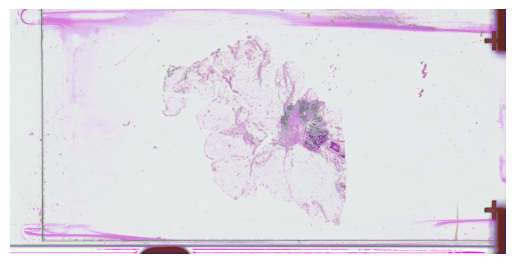

In [8]:
plt.imshow(prediction)
plt.axis('off')
plt.show()

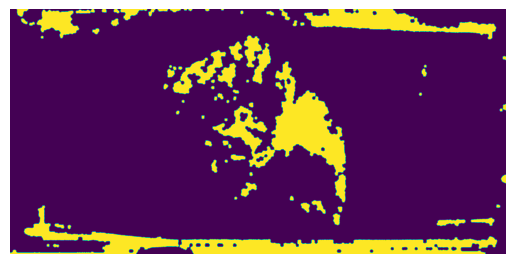

In [9]:
mask = get_tissue_mask(prediction, use_laplacian=True)
plt.imshow(mask)
plt.axis('off')
plt.show()

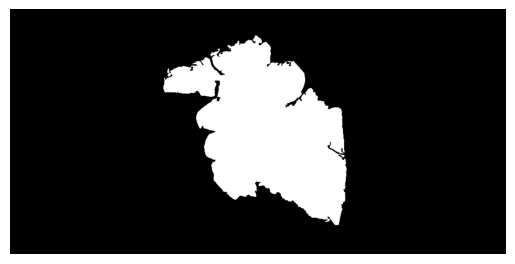

In [10]:
path_mask = os.path.join(path_masks_base, os.path.splitext(filename_curr)[0] + '_mask.tif')
img_mask = load_image(path_mask)
plt.imshow(img_mask)
plt.axis('off')
plt.show()